In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Apple Disease Prediction

## Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F #relu,GD
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, ToPILImage

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc

from PIL import Image, ImageOps
import random

In [2]:
#setdevice
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Exploring Data

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    RandomResizedCrop((224, 224), scale=(0.8, 1.0)),  # Random crop and resize
    RandomHorizontalFlip(p=0.5),            # Randomly flip horizontally with 50% probability
    transforms.ToTensor(),
])

In [4]:
#Create Dataset
train_root = r"/kaggle/input/apple-disease-dataset/datasets/train"
test_root = r"/kaggle/input/apple-disease-dataset/datasets/test"

In [5]:
train_dataset = ImageFolder(train_root , transform =transform)
train_set,val_set = torch.utils.data.random_split(train_dataset,[6217,1554])
test_dataset = ImageFolder(test_root , transform =transform)
#DataLoader
train_loader = DataLoader(train_set,batch_size = 64,shuffle = True,drop_last=True)
val_loader = DataLoader(val_set, batch_size = 64,drop_last = True)
test_loader = DataLoader(test_dataset,batch_size = 64,drop_last = True)

In [6]:
class_names = train_dataset.classes
class_names

['apple_scab', 'black_rot', 'cedar_apple_rust', 'healthy']

In [7]:
len_train = len(train_set)
len_val = len(val_set)
print(len_train,len_val)
print(train_dataset.class_to_idx)

6217 1554
{'apple_scab': 0, 'black_rot': 1, 'cedar_apple_rust': 2, 'healthy': 3}


In [8]:
# Function to display 10 images from the dataset
def show_images(loader, num_images=10):
    # Get a batch of images and labels
    data_iter = iter(loader)
    images, labels = next(data_iter)  # Use `next(data_iter)` to get the first batch
    
    # Select first 'num_images' images
    images = images[:num_images]
    labels = labels[:num_images]
    
    # Set up the plot with 2 rows and 5 columns
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns
    for idx in range(num_images):
        row = idx // 5  # Determine the row index
        col = idx % 5   # Determine the column index
        image = images[idx].numpy().transpose(1, 2, 0)  # Transpose to (H, W, C) for displaying
        image = (image - image.min()) / (image.max() - image.min())  # Normalize the image
        label = class_names[labels[idx]]
        axes[row, col].imshow(image)
        axes[row, col].set_title(label)
        axes[row, col].axis('off')
    plt.show()


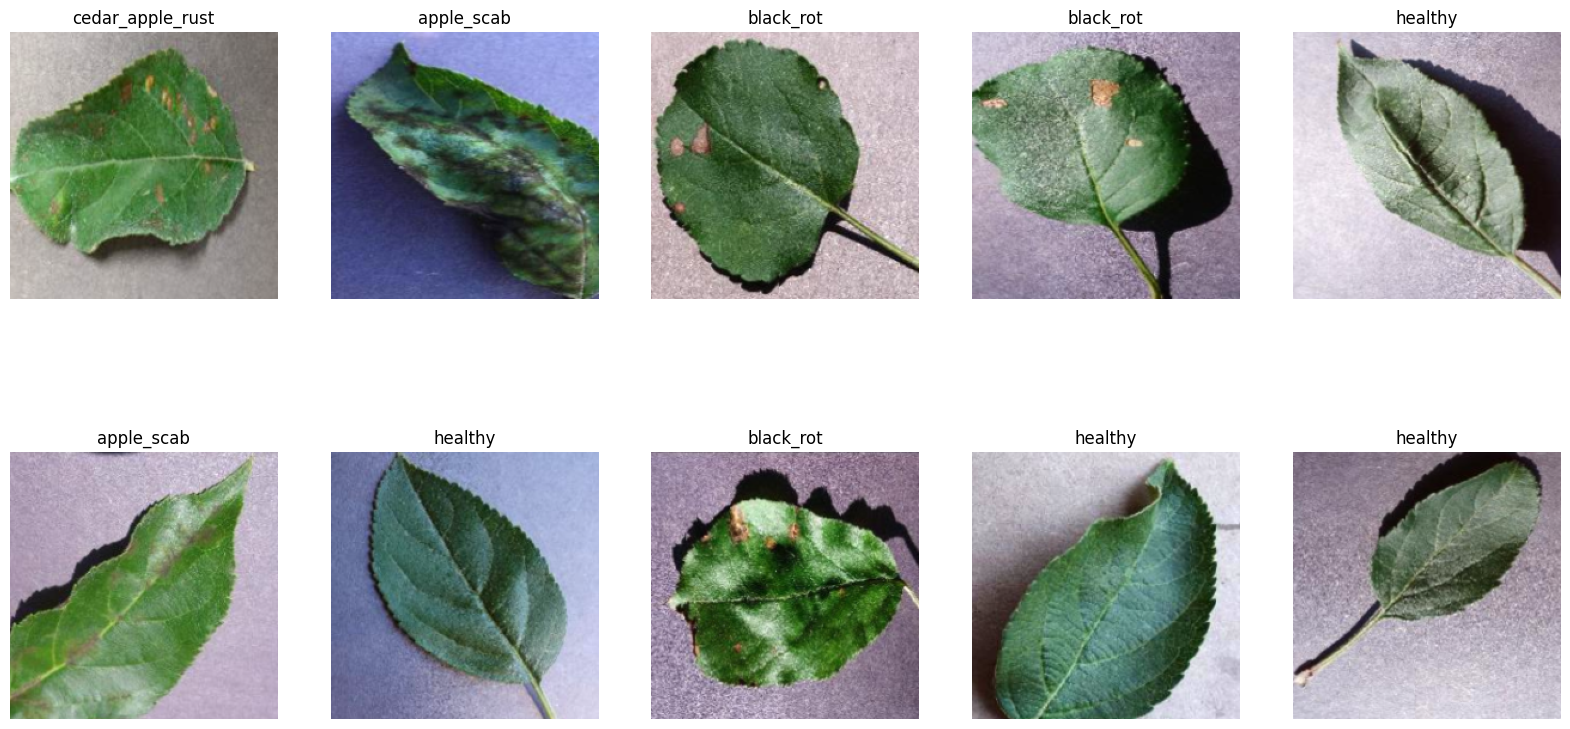

In [9]:
show_images(train_loader)

## Creating Model Architecture 

In [10]:
# pretrained model
model = resnet50(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
model.fc =nn.Linear(in_features = 2048 , out_features = 4 )
model = model.to(device)
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
optimizer = optim.Adam(model.fc.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()

## Model Development on Training Data

In [14]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device, class_names):
    """
    Train and validate a PyTorch model.

    Args:
        model (torch.nn.Module): The PyTorch model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        epochs (int): Number of epochs to train the model.
        device (torch.device): Device to run the model on ('cuda' or 'cpu').
        class_names (list): List of class names for the classification report.

    Returns:
        tuple: (train_losses, val_losses, train_accuracies, val_accuracies)
    """

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        total_train_loss = 0.0
        total_train_samples = 0
        total_train_correct = 0
        
        model.train()
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            loss = criterion(scores, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_samples += data.size(0)

            # Calculate training accuracy after each batch
            _, predictions = scores.max(1)
            total_train_correct += (predictions == targets).sum().item()

        # Calculate average training loss per epoch and Accuracy
        epoch_train_loss = (total_train_loss / total_train_samples)
        train_losses.append(epoch_train_loss)
        
        epoch_train_accuracy = (total_train_correct / total_train_samples) * 100
        train_accuracies.append(epoch_train_accuracy)

        # Validation Loop
        model.eval()
        num_correct = 0
        num_samples = 0
        total_val_loss = 0.0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)    

                scores = model(x)
                loss = criterion(scores, y)
                total_val_loss += loss.item() 

                _, predictions = scores.max(1)
                num_correct += (predictions == y).sum().item()
                num_samples += y.size(0)
                val_predictions.extend(predictions.cpu().numpy())
                val_targets.extend(y.cpu().numpy())

            val_acc = (float(num_correct) / float(num_samples)) * 100
            val_loss = total_val_loss / num_samples
            # Calculate average validation loss per epoch and Accuracy
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

        print(f'Epoch {epoch + 1}/{epochs} | Validation Accuracy: {val_acc:.2f}% | Validation Loss: {val_loss:.4f}')

    # Classification report for validation data
    val_report = classification_report(val_targets, val_predictions, target_names=class_names)
    print("\nClassification Report - Validation Data:")
    print(val_report)

    model.train()  # Set the model back to training mode

    return train_losses, val_losses, train_accuracies, val_accuracies

In [15]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = 10

for epoch in range(epochs):
    total_train_loss = 0.0
    total_train_samples = 0
    total_train_correct = 0
    
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_samples += data.size(0)

        # Calculate training accuracy after each batch
        _, predictions = scores.max(1)
        total_train_correct += (predictions == targets).sum().item()

    # Calculate average training loss per epoch and Accuracy
    epoch_train_loss = (total_train_loss / total_train_samples)
    train_losses.append(epoch_train_loss)
    
    epoch_train_accuracy = (total_train_correct / total_train_samples)*100
    train_accuracies.append(epoch_train_accuracy)


    # Validation Loop
    model.eval()
    num_correct = 0
    num_samples = 0
    total_val_loss = 0.0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)    

            scores = model(x)
            loss = criterion(scores, y)
            total_val_loss += loss.item() 

            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum().item()
            num_samples += y.size(0)
            val_predictions.extend(predictions.cpu().numpy())
            val_targets.extend(y.cpu().numpy())

        val_acc = (float(num_correct) /float(num_samples)) * 100
        val_loss = total_val_loss / num_samples
        # Calculate average validation loss per epoch and Accuracy
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    print(f'Epoch {epoch + 1}/{epochs} | Validation Accuracy: {val_acc:.2f} | Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_acc:.2f} | Validation Loss: {val_loss:.4f}')
# Classification report for validation data
val_report = classification_report(val_targets, val_predictions, target_names=train_dataset.classes)
print("Classification Report - Validation Data:")
print(val_report)

model.train()

Epoch 1/10 | Validation Accuracy: 97.85 | Validation Loss: 0.0021
Epoch 2/10 | Validation Accuracy: 98.63 | Validation Loss: 0.0018
Epoch 3/10 | Validation Accuracy: 97.66 | Validation Loss: 0.0019
Epoch 4/10 | Validation Accuracy: 98.05 | Validation Loss: 0.0018
Epoch 5/10 | Validation Accuracy: 98.70 | Validation Loss: 0.0017
Epoch 6/10 | Validation Accuracy: 98.44 | Validation Loss: 0.0016
Epoch 7/10 | Validation Accuracy: 98.24 | Validation Loss: 0.0015
Epoch 8/10 | Validation Accuracy: 98.11 | Validation Loss: 0.0015
Epoch 9/10 | Validation Accuracy: 98.31 | Validation Loss: 0.0014
Epoch 10/10 | Validation Accuracy: 98.83 | Validation Loss: 0.0013
Validation Accuracy: 98.83 | Validation Loss: 0.0013
Classification Report - Validation Data:
                  precision    recall  f1-score   support

      apple_scab       0.98      0.98      0.98       385
       black_rot       1.00      1.00      1.00       380
cedar_apple_rust       0.98      0.99      0.99       358
         hea

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
x.shape,y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [18]:
print("train_losses:", train_losses)
print("val_losses:", val_losses)
print("train_accuracies:", train_accuracies)
print("val_accuracies:", val_accuracies)

train_losses: [0.002535900713146194, 0.00234957236542184, 0.0022439334227117836, 0.0021280479010136934, 0.0019504618074879358, 0.0018603120373619586, 0.001707793067607875, 0.0016697313043663336, 0.0016609797831480728, 0.0016118478733258917]
val_losses: [0.0021482960582943633, 0.0018454513871499028, 0.0019390495193268482, 0.0017582712753210217, 0.001671703304358137, 0.0016053276825308178, 0.0015086554897910294, 0.0015375615936742786, 0.0014014596963534132, 0.001326082138499866]
train_accuracies: [97.47100515463917, 97.66430412371135, 97.76095360824742, 97.51932989690721, 98.03479381443299, 98.06701030927834, 98.4213917525773, 98.01868556701031, 97.9381443298969, 98.05090206185567]
val_accuracies: [97.8515625, 98.6328125, 97.65625, 98.046875, 98.69791666666666, 98.4375, 98.2421875, 98.11197916666666, 98.30729166666666, 98.828125]


### Visualizations

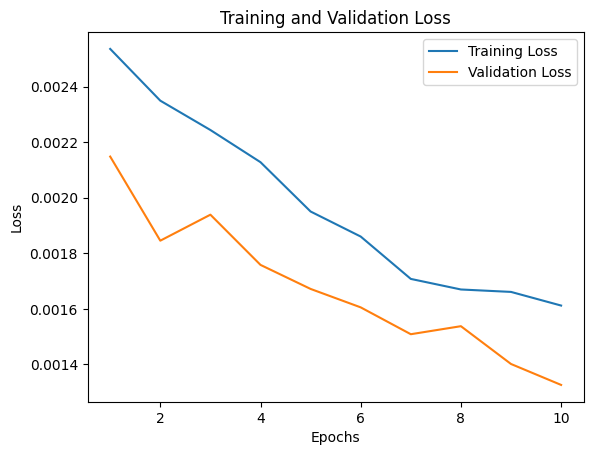

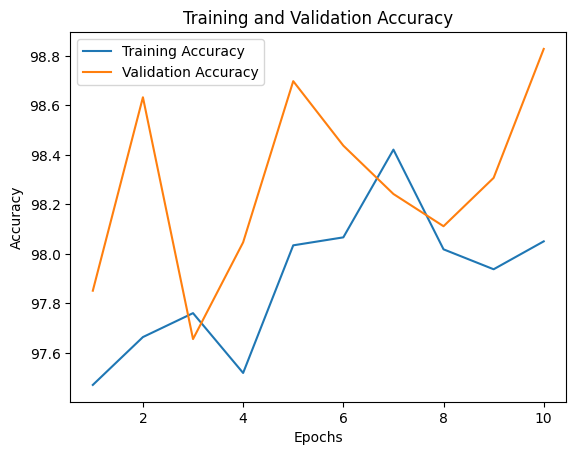

In [19]:
epochs = range(1, len(train_losses) + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Accuracy plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

## Model Evaluation on Testing Data

In [20]:
# Testing Loop
model.eval()
num_correct = 0
num_samples = 0
test_loss = 0
test_predictions = []
test_targets = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        scores = model(x)
        loss = criterion(scores,y)
        test_loss += loss.item()
        _, predictions = scores.max(1)
        num_correct += (predictions == y).sum().item()
        num_samples += predictions.size(0)
        test_predictions.extend(predictions.cpu().numpy())
        test_targets.extend(y.cpu().numpy())

test_acc = (float(num_correct) / float(num_samples)) * 100
test_loss /= num_samples

print(f'Testing Accuracy: {test_acc:.2f}| Testing_loss:{test_loss:.4f}')
test_report = classification_report(test_targets, test_predictions, target_names=test_dataset.classes)
print("Classification Report - Testing Data:")
print(test_report)
model.train()

Testing Accuracy: 98.96| Testing_loss:0.0013
Classification Report - Testing Data:
                  precision    recall  f1-score   support

      apple_scab       0.97      0.99      0.98       504
       black_rot       0.99      0.99      0.99       497
cedar_apple_rust       1.00      0.99      1.00       440
         healthy       1.00      0.98      0.99       479

        accuracy                           0.99      1920
       macro avg       0.99      0.99      0.99      1920
    weighted avg       0.99      0.99      0.99      1920



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# Function to predict and display the class of a test image
def predict_and_show(image, model, transform, class_names):
    model.eval()
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

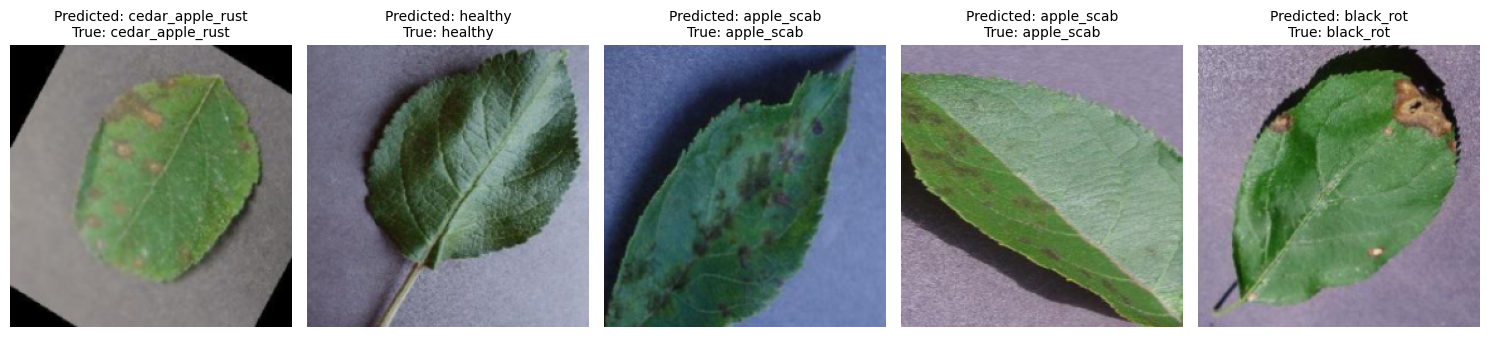

Accuracy on 5 randomly selected test images: 100.00%


In [29]:
# Function to predict and display the class of a test image
def predict_and_show(image, model, transform, class_names):
    model.eval()
    to_pil = ToPILImage()
    image = to_pil(image)  # Convert tensor to PIL Image
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Randomly select 5 images from the test dataset
random_indices = random.sample(range(len(test_dataset)), 5)
random_images = [test_dataset[i][0] for i in random_indices]  # Tensors
random_labels = [test_dataset.targets[i] for i in random_indices]

# Predict and display the class of the selected images
correct_predictions = 0
plt.figure(figsize=(15, 5))  # Increase the figure size for better spacing
for i, (image, true_label) in enumerate(zip(random_images, random_labels)):
    predicted_class = predict_and_show(image, model, transform, class_names)
    true_class = class_names[true_label]
    if predicted_class == true_class:
        correct_predictions += 1

    plt.subplot(1, 5, i + 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(f'Predicted: {predicted_class}\nTrue: {true_class}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate and print the accuracy
accuracy = (correct_predictions / 5) * 100
print(f'Accuracy on 5 randomly selected test images: {accuracy:.2f}%')

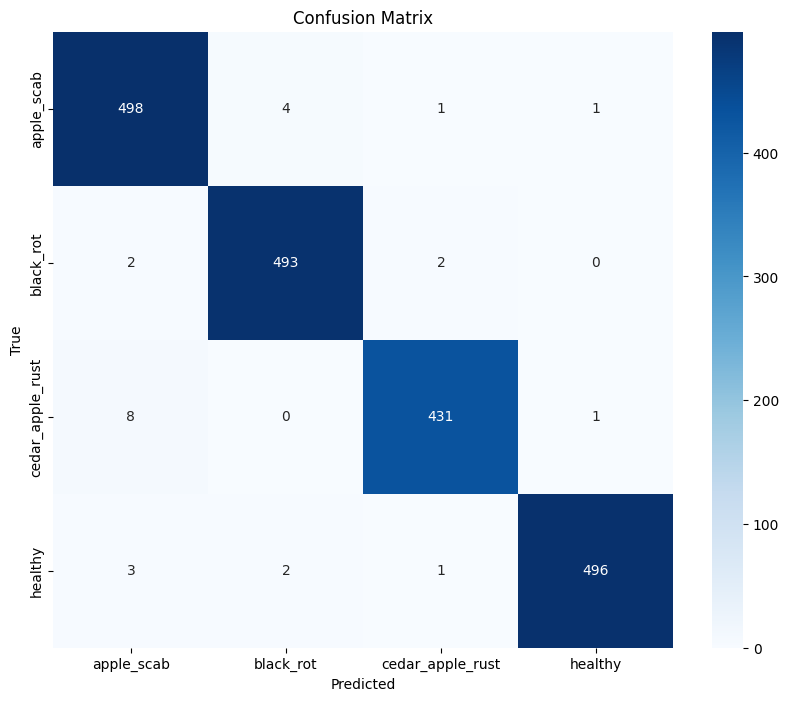

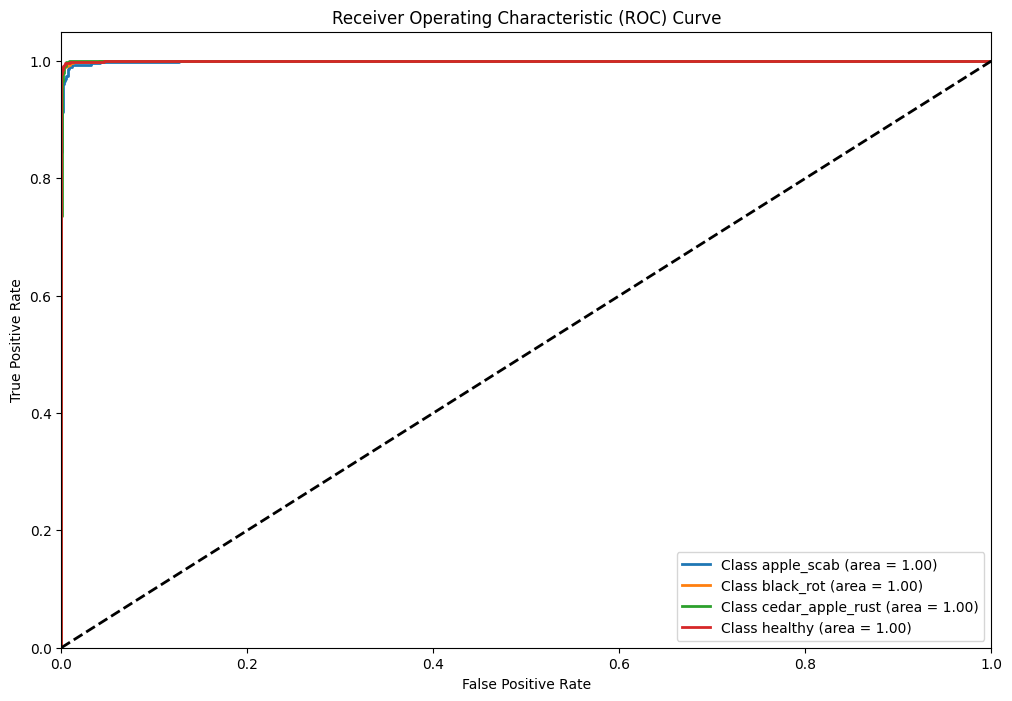

In [31]:
# Make predictions on the entire test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
all_preds = []
all_labels = []
all_probs = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot the ROC curve for each class
plt.figure(figsize=(12, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


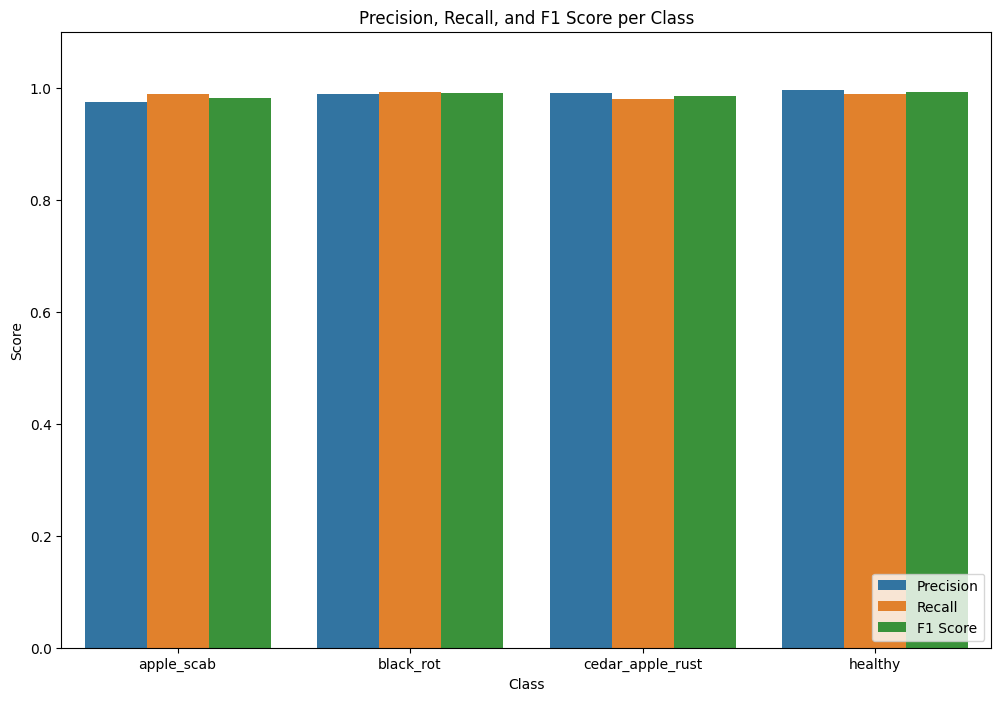

In [34]:
# Calculate precision, recall, and f1-score
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

# Extract metrics for each class
precision = [report[class_name]['precision'] for class_name in class_names]
recall = [report[class_name]['recall'] for class_name in class_names]
f1_score = [report[class_name]['f1-score'] for class_name in class_names]

# Create a DataFrame for plotting
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
})

# Melt the DataFrame for seaborn
metrics_df = metrics_df.melt(id_vars='Class', var_name='Metric', value_name='Value')

# Plot the metrics using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df)
plt.title('Precision, Recall, and F1 Score per Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.show()